In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
rooth_path = '../data/training/'
power_df = pd.read_csv(rooth_path + 'Power_curve.csv')
failures_df = pd.read_csv(rooth_path + 'wind-farm-1-failures-training.csv')
signals_df = pd.read_csv(rooth_path + 'wind-farm-1-signals-training.csv', delimiter=';')
logs_df = pd.read_csv(rooth_path + 'wind-farm-1-logs-training.csv')
met_df = pd.read_csv(rooth_path + 'wind-farm-1-metmast-training.csv', delimiter=';')

# 

According to the case study, the components to be monitored will be:
- Gearbox
- Generator
- Generator Bearing
- Transformer
- Hydraulic Group



We have 4 important dataframes to analyze:
- failures_df - failures by time and turbine
- signals_df - SCADA signals for each turbine across time
- logs_df - regist of logs for each turbine across time
- met_df - metereological data in the region of the wind farm

### Steps:

- Prepare dataframes to merge with failures_df
- Compute Time to Failure (TTF) for binary classification
- We could label the whole dataset, do the train-test split and drop the last two months of the training data to avoid dataleakage. Since we have a small dataset we will do the train test split first, so we don't loose too much information
- See how to use the logs_df, maybe also labeling this datasets and do some feature exploration
- Feature Selection
- Feature Engineering
- Train and evaluate

Note: these are a draft steps that may differ in the analysis process

In [3]:
# transform all the Timestamps to date-time format
failures_df['Timestamp'] = pd.to_datetime(failures_df['Timestamp'])
logs_df['TimeDetected'] = pd.to_datetime(logs_df['TimeDetected'])
met_df['Timestamp'] = pd.to_datetime(met_df['Timestamp'])
signals_df['Timestamp'] = pd.to_datetime(signals_df['Timestamp'])

In [4]:
logs_df.head()

,TimeDetected,TimeReset,UnitTitle,Remark,UnitTitleDestination
0,2016-01-01 00:02:18+00:00,NaN,T11,External power ref.:2000kW,NaN
1,2016-01-01 00:07:15+00:00,NaN,T06,Generator 1 in,NaN
2,2016-01-01 00:11:33+00:00,NaN,T09,External power ref.:2000kW,NaN
3,2016-01-01 00:15:27+00:00,NaN,T01,Generator 1 in,NaN
4,2016-01-01 00:15:44+00:00,NaN,T01,External power ref.:2000kW,NaN


In [5]:
signals_df.head()

,Turbine_ID,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,...,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg,Nac_Direction_Avg
0,T11,2016-01-01 00:00:00+00:00,1339.4,1233.3,1270.9,18.8,42.0,59,61,60,...,-973.4,-752.6,-1000.0,56.5,973.4,1000.0,752.6,56.5,38,206.9
1,T06,2016-01-01 00:00:00+00:00,1270.0,1232.8,1248.5,6.8,42.0,51,52,53,...,-307.1,0.0,-880.6,180.0,307.1,880.6,0.0,180.0,35,204.6
2,T01,2016-01-01 00:00:00+00:00,1277.4,1226.1,1249.0,9.0,41.0,58,59,58,...,-144.4,0.0,-584.5,157.1,144.4,584.5,0.0,157.1,37,218.5
3,T09,2016-01-01 00:00:00+00:00,1376.7,1234.3,1272.0,24.7,40.0,58,57,58,...,-861.6,-224.5,-1000.0,185.5,861.6,1000.0,224.5,185.5,33,214.0
4,T07,2016-01-01 00:00:00+00:00,1317.5,1229.5,1254.9,13.8,41.0,62,62,61,...,-536.5,0.0,-1000.0,338.9,536.5,1000.0,0.0,338.9,39,197.3


In [6]:
failures_df.head()

,Turbine_ID,Component,Timestamp,Remarks
0,T11,GENERATOR,2016-03-03 19:00:00+00:00,Electric circuit error in generator
1,T06,HYDRAULIC_GROUP,2016-04-04 18:53:00+00:00,Error in pitch regulation
2,T07,GENERATOR_BEARING,2016-04-30 12:40:00+00:00,High temperature in generator bearing (replace...
3,T09,GENERATOR_BEARING,2016-06-07 16:59:00+00:00,High tempemperature generator bearing
4,T07,TRANSFORMER,2016-07-10 03:46:00+00:00,High temperature transformer


In [7]:
met_df.head()

,Timestamp,Min_Windspeed1,Max_Windspeed1,Avg_Windspeed1,Var_Windspeed1,Min_Windspeed2,Max_Windspeed2,Avg_Windspeed2,Var_Windspeed2,Min_Winddirection2,...,Anemometer1_CorrOffset,Anemometer2_Freq,Anemometer2_Offset,Anemometer2_CorrGain,Anemometer2_CorrOffset,DistanceAirPress,AirRessureSensorZeroOffset,Anemometer1_Avg_Freq,Anemometer2_Avg_Freq,Pressure_Avg_Freq
0,2016-01-01 00:00:00+00:00,3.7,6.0,5.1,0.21,3.8,6.0,5.1,0.22,236.0,...,0,0.0499,0.24,1,0,0,600,98,99,418
1,2016-01-01 00:10:00+00:00,4.1,6.0,5.1,0.09,4.1,6.0,5.2,0.10,236.0,...,0,0.0499,0.24,1,0,0,600,99,101,418
2,2016-01-01 00:20:00+00:00,4.5,6.7,5.7,0.26,4.4,6.8,5.8,0.30,236.0,...,0,0.0499,0.24,1,0,0,600,111,113,418
3,2016-01-01 00:30:00+00:00,5.1,7.0,6.3,0.11,5.1,7.1,6.4,0.12,236.0,...,0,0.0499,0.24,1,0,0,600,122,125,418
4,2016-01-01 00:40:00+00:00,4.7,7.3,6.2,0.27,4.9,7.4,6.3,0.27,236.0,...,0,0.0499,0.24,1,0,0,600,121,123,417


### Work on SCADA signals DF

In [8]:
signals_df.shape

(434146, 83)

In [9]:
signals_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Gen_RPM_Max,434146.0,1180.311232,642.006149,0.0,303.7,1421.10,1681.9,2040.9
Gen_RPM_Min,434146.0,923.318816,614.934920,0.0,183.9,1231.30,1369.4,1672.0
Gen_RPM_Avg,434146.0,1055.187177,617.817428,0.0,261.4,1276.80,1592.3,1684.4
Gen_RPM_Std,434146.0,68.819540,112.115053,0.0,14.0,28.50,70.8,823.2
Gen_Bear_Temp_Avg,434139.0,47.068904,17.601397,12.0,35.0,44.00,57.0,205.0
...,...,...,...,...,...,...,...,...
Grd_Prod_PsbleCap_Max,434146.0,662.076773,438.854025,0.0,0.0,1000.00,1000.0,1000.0
Grd_Prod_PsbleCap_Min,434146.0,320.134403,354.558858,-200.0,0.0,249.35,495.2,1000.0
Grd_Prod_PsbleCap_Std,434146.0,82.694136,100.024735,0.0,0.0,32.40,155.0,500.0
Gen_Bear2_Temp_Avg,434146.0,43.381607,14.201788,13.0,33.0,41.00,53.0,205.0


In [10]:
signals_df.dtypes

Turbine_ID                            object
Timestamp                datetime64[ns, UTC]
Gen_RPM_Max                          float64
Gen_RPM_Min                          float64
Gen_RPM_Avg                          float64
                                ...         
Grd_Prod_PsbleCap_Max                float64
Grd_Prod_PsbleCap_Min                float64
Grd_Prod_PsbleCap_Std                float64
Gen_Bear2_Temp_Avg                     int64
Nac_Direction_Avg                    float64
Length: 83, dtype: object

In [11]:
signals_df.isnull().sum().sum()

14

In [12]:
# Group by Turbine_ID and Timestamp
signals_df = signals_df.groupby(['Turbine_ID', 'Timestamp']).mean().reset_index()

In [13]:
# Fill null values by interpolation within each turbine
turbines = ['T01', 'T06', 'T07', 'T09', 'T11']
df_ = pd.DataFrame(columns=signals_df.columns)
for turbine in turbines:
    temp = signals_df[signals_df['Turbine_ID']==turbine]
    temp = temp.interpolate(method='bfill', axis=0)
    df_ = pd.concat([df_, temp])
signals_df = df_.copy()

In [14]:
# Since we have very granular records, we will group by day the SCADA signals
signals_df['Date'] = signals_df['Timestamp'].dt.date
signals_df = signals_df.groupby(by=['Turbine_ID','Date']).mean().reset_index()

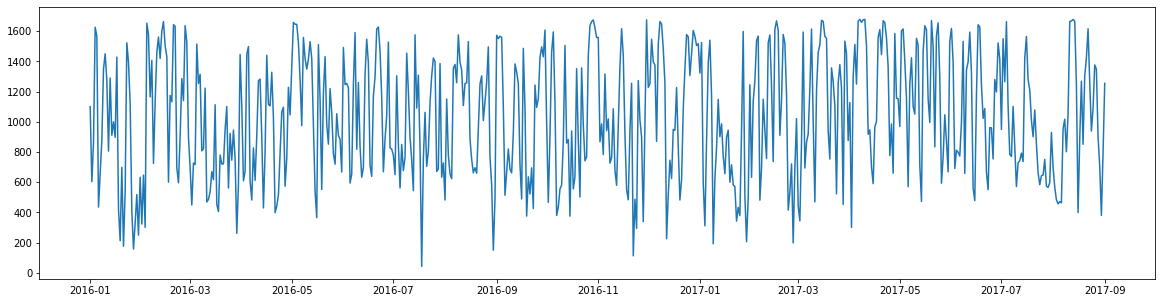

In [15]:
#See chronological behaviour of one feature in T01
temp = signals_df[signals_df['Turbine_ID']=='T01']
plt.figure(figsize=(20,5)) 
plt.plot(temp['Date'], temp['Gen_RPM_Avg'])

### Work on meteorological DF

In [16]:
met_df.shape

(69961, 41)

In [17]:
met_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Min_Windspeed1,69960.0,4.245343,2.654873e+00,0.0000,2.3000,3.7000,5.8000,17.8000
Max_Windspeed1,69961.0,8.413618,4.808946e+00,0.0000,4.7000,7.5000,11.3000,30.8000
Avg_Windspeed1,69960.0,6.338668,3.733035e+00,0.0000,3.5000,5.6000,8.5000,23.1000
Var_Windspeed1,69960.0,0.926280,1.213568e+00,0.0000,0.1500,0.4800,1.1900,35.1000
Min_Windspeed2,69960.0,4.341732,2.796495e+00,0.0000,2.2000,3.8000,6.0000,17.3000
Max_Windspeed2,69961.0,8.317262,4.693258e+00,0.0000,4.7000,7.5000,11.2000,29.0000
Avg_Windspeed2,69960.0,6.338642,3.740070e+00,0.0000,3.5000,5.6000,8.6000,22.9000
Var_Windspeed2,69960.0,0.807165,9.985055e-01,0.0000,0.1500,0.4700,1.0600,35.9300
Min_Winddirection2,69960.0,232.267953,2.458751e+01,0.0000,236.0000,236.0000,236.0000,358.0000
Max_Winddirection2,69961.0,233.634939,1.868413e+01,0.0000,236.0000,236.0000,236.0000,357.0000


#### We can already see that there are some features that we can mark for elimination because of std~0  

In [18]:
met_df.dtypes

Timestamp                     datetime64[ns, UTC]
Min_Windspeed1                            float64
Max_Windspeed1                            float64
Avg_Windspeed1                            float64
Var_Windspeed1                            float64
Min_Windspeed2                            float64
Max_Windspeed2                            float64
Avg_Windspeed2                            float64
Var_Windspeed2                            float64
Min_Winddirection2                        float64
Max_Winddirection2                          int64
Avg_Winddirection2                        float64
Var_Winddirection2                        float64
Min_AmbientTemp                           float64
Max_AmbientTemp                             int64
Avg_AmbientTemp                           float64
Min_Pressure                              float64
Max_Pressure                                int64
Avg_Pressure                              float64
Min_Humidity                              float64


In [19]:
met_df.isnull().sum()

Timestamp                     0
Min_Windspeed1                1
Max_Windspeed1                0
Avg_Windspeed1                1
Var_Windspeed1                1
Min_Windspeed2                1
Max_Windspeed2                0
Avg_Windspeed2                1
Var_Windspeed2                1
Min_Winddirection2            1
Max_Winddirection2            0
Avg_Winddirection2            1
Var_Winddirection2            3
Min_AmbientTemp               1
Max_AmbientTemp               0
Avg_AmbientTemp               1
Min_Pressure                  1
Max_Pressure                  0
Avg_Pressure                  1
Min_Humidity                  1
Max_Humidity                  0
Avg_Humidity                  1
Min_Precipitation             0
Max_Precipitation             0
Avg_Precipitation             0
Min_Raindetection             0
Max_Raindetection             0
Avg_Raindetection             0
Anemometer1_Freq              0
Anemometer1_Offset            0
Anemometer1_CorrGain          0
Anemomet

In [20]:
# Fill null values by interpolation
met_df = met_df.interpolate(method='bfill', axis=0)

In [21]:
# Since we have very granular records, we will group by day the meteorological data signals
met_df['Date'] = met_df['Timestamp'].dt.date
met_df = met_df.groupby(by=['Date']).mean().reset_index()

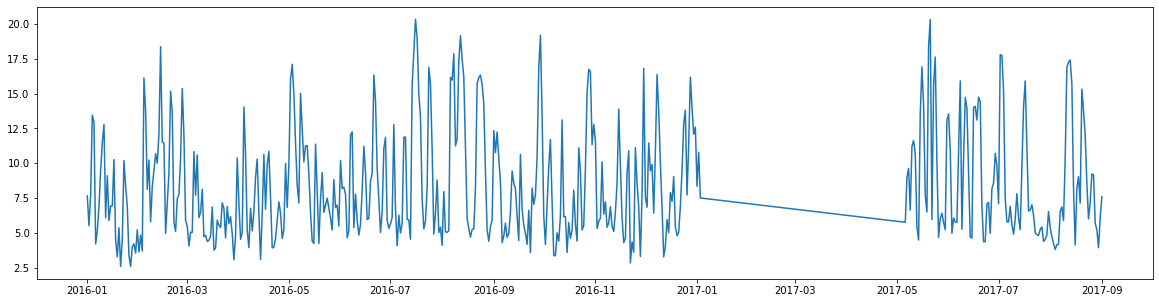

In [22]:
# See chronological behaviour of one feature
plt.figure(figsize=(20,5)) 
plt.plot(met_df['Date'], met_df['Max_Windspeed1'])

### Since we have a lack of information between the period of January-May 2017 let's forget for now the meteorological data. 

### Work on Logs DF

In [23]:
logs_df.head()

,TimeDetected,TimeReset,UnitTitle,Remark,UnitTitleDestination
0,2016-01-01 00:02:18+00:00,NaN,T11,External power ref.:2000kW,NaN
1,2016-01-01 00:07:15+00:00,NaN,T06,Generator 1 in,NaN
2,2016-01-01 00:11:33+00:00,NaN,T09,External power ref.:2000kW,NaN
3,2016-01-01 00:15:27+00:00,NaN,T01,Generator 1 in,NaN
4,2016-01-01 00:15:44+00:00,NaN,T01,External power ref.:2000kW,NaN


In [24]:
# Sort by UnitTitle and TimeDetected
logs_df.sort_values(by=['UnitTitle', 'TimeDetected'], inplace=True)

In [25]:
logs_df.head()

,TimeDetected,TimeReset,UnitTitle,Remark,UnitTitleDestination
3,2016-01-01 00:15:27+00:00,NaN,T01,Generator 1 in,NaN
4,2016-01-01 00:15:44+00:00,NaN,T01,External power ref.:2000kW,NaN
10,2016-01-01 00:45:43+00:00,NaN,T01,External power ref.:2000kW,NaN
15,2016-01-01 01:15:43+00:00,NaN,T01,External power ref.:2000kW,NaN
20,2016-01-01 01:45:43+00:00,NaN,T01,External power ref.:2000kW,NaN


In [26]:
#Drop Columns we will not use
logs_df = logs_df.drop(columns=['UnitTitleDestination'])

In [27]:
logs_df['Remark'].nunique()

5051

In [28]:
# See how many error messages we have in the logs_df
print(logs_df['Remark'].str.contains('rror').sum())

176


### Work on Failures DF

In [29]:
failures_df.head()

,Turbine_ID,Component,Timestamp,Remarks
0,T11,GENERATOR,2016-03-03 19:00:00+00:00,Electric circuit error in generator
1,T06,HYDRAULIC_GROUP,2016-04-04 18:53:00+00:00,Error in pitch regulation
2,T07,GENERATOR_BEARING,2016-04-30 12:40:00+00:00,High temperature in generator bearing (replace...
3,T09,GENERATOR_BEARING,2016-06-07 16:59:00+00:00,High tempemperature generator bearing
4,T07,TRANSFORMER,2016-07-10 03:46:00+00:00,High temperature transformer


In [30]:
# Timestamp to date
failures_df['Date'] = failures_df['Timestamp'].dt.date

# Just remove the 'Remarks' and 'Timestamp' columns
failures_df = failures_df.drop(columns=['Remarks', 'Timestamp'])

In [31]:
# Dummies for the Component
failures_df = pd.get_dummies(failures_df, columns=['Component'])

# Prepare Data 

Note: We are aware that the logs_df may add value to our future analysis, but we will continue working for now without it

#### We will study each component seperatly, so we will do a dataframe for each of the components to analyze, by choosing the correct input features of each component, based on the EDP SCADA signals explanation

In [32]:
# Function to find str in columns of df
def component(component, col):
    
    '''Find a string in columns'''
    
    pair_comp_col=[]
    for i in col:
        if component in i:
            pair_comp_col.append(i)
            
    return pair_comp_col

In [33]:
# Function to choose the right features of each component
def choose_features(df):
    
    '''Choose the correct input features of each component '''
    
    important_signals = ['Turbine_ID', 'Date', 'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg', 'Gen_RPM_Std', 
                     'Gen_Bear_Temp_Avg', 'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 
                     'Hyd_Oil_Temp_Avg','Gear_Oil_Temp_Avg', 'Gear_Bear_Temp_Avg', 'Nac_Temp_Avg', 'Amb_WindSpeed_Max', 
                     'Amb_WindSpeed_Min', 'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std', 'Amb_Temp_Avg',
                     'Prod_LatestAvg_TotActPwr', 'Prod_LatestAvg_TotReactPwr','HVTrafo_Phase1_Temp_Avg', 
                     'HVTrafo_Phase2_Temp_Avg', 'HVTrafo_Phase3_Temp_Avg', 'Grd_InverterPhase1_Temp_Avg', 'Cont_Top_Temp_Avg',
                     'Cont_Hub_Temp_Avg', 'Cont_VCP_Temp_Avg', 'Gen_SlipRing_Temp_Avg', 'Spin_Temp_Avg', 'Blds_PitchAngle_Max', 
                     'Blds_PitchAngle_Min', 'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std', 'Grd_Prod_Pwr_Avg',
                     'Grd_Busbar_Temp_Avg', 'Gen_Bear2_Temp_Avg', 'Nac_Direction_Avg']
    
    df_ = df[important_signals]
    
    time_id = ['Turbine_ID', 'Date']
    pair_gen = component('Gen', df_.columns)
    pair_hyd = component('Hyd', df_.columns)
    pair_transf = component('Trafo', df_.columns)
    pair_gear = component('Gear', df_.columns)
    pair_amb = component('Amb', df_.columns)
    pair_blds = component('Blds', df_.columns)
    pair_cont = component('Cont', df_.columns)
    pair_nac = component('Nac', df_.columns)
    pair_spin = component('Spin', df_.columns)
    pair_bus = component('Busbar', df_.columns)
    
    #Create DF for each component
    df_generator = df[time_id + pair_gen + pair_amb + pair_blds + pair_cont + pair_nac + pair_spin + pair_bus]
    df_gen_bear = df[time_id + pair_gen + pair_amb + pair_blds + pair_cont + pair_nac + pair_spin + pair_bus]
    df_transformer = df[time_id + pair_transf + pair_amb + pair_blds + pair_cont + pair_nac + pair_spin + pair_bus] 
    df_hydraulic = df[time_id + pair_hyd + pair_amb + pair_blds + pair_cont + pair_nac + pair_spin + pair_bus] 
    df_gearbox = df[time_id + pair_gear + pair_amb + pair_blds + pair_cont + pair_nac + pair_spin + pair_bus]
    
    return df_generator, df_gen_bear, df_transformer, df_hydraulic, df_gearbox

In [34]:
# Function to do the df of component failure
def choose_failure(df):
    
    '''Compute the Dataframe of failures for each component '''
    
    # Rename de column Generator Bearing to avoid mistakes with the column Generator
    df.rename(columns={"Component_GENERATOR_BEARING": "Component_BEARING"}, inplace=True)
    
    time_id = ['Turbine_ID', 'Date']
    gen = component('GENERATOR', df.columns)
    gen_bear = component('BEARING', df.columns)
    transf = component('TRANSFORMER', df.columns)
    hyd = component('HYDRAULIC', df.columns)
    gearbox = component('GEARBOX', df.columns)
    
    #Create DF for each component failure
    df_fail_gen = df[time_id + gen]
    df_fail_gen_bear = df[time_id + gen_bear]
    df_fail_transf = df[time_id + transf] 
    df_fail_hyd = df[time_id + hyd] 
    df_fail_gearbox = df[time_id + gearbox]
    
    return df_fail_gen, df_fail_gen_bear, df_fail_transf, df_fail_hyd, df_fail_gearbox

#### Do the train test split before any other operation to avoid data leakage and leave the test set completly unseen

In [35]:
# Fucntion for split without shuffling
def split_df(df):
    
    '''Train Test Split'''
    
    # DateTime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # period to split 
    split = '2017-01-01'
    
    # Train and Test split
    df_train = df[df['Date'] < split]
    df_test = df[df['Date'] >= split]
    
    return df_train, df_test

#### Data Augmentation

In [36]:
# Function for Rolling Aggregates
def add_features(df, rolling_win_size):
    
    ''' Do rolling aggregates'''

    cols = df.columns
    
    rol_av_cols = [nm +'_av' for nm in cols]
    rol_sd_cols = [nm +'_sd' for nm in cols]
    
    # New empty dataframe
    df_out = pd.DataFrame()
    
    ws = rolling_win_size
    
    #calculate rolling stats for each turbine
    
    for n_id in pd.unique(df.Turbine_ID):
    
        # get a subset for each turbine sensors
        df_turbine = df[df['Turbine_ID'] == n_id]
        df_sub = df_turbine[cols]

    
        # get rolling mean for the subset
        rol_av = df_sub.rolling(ws, min_periods=1).mean()
        rol_av.columns = rol_av_cols
    
        # get the rolling standard deviation for the subset
        rol_sd = df_sub.rolling(ws, min_periods=1).std().fillna(0)
        rol_sd.columns = rol_sd_cols
    
        # combine the two new subset dataframes columns to the turbine subset
        new_ftrs = pd.concat([df_turbine, rol_av, rol_sd], axis=1)
    
        # add the new features rows to the output dataframe
        df_out = pd.concat([df_out, new_ftrs])
        
    df_out_ = df_out.drop(columns=['Turbine_ID_av', 'Date_av', 'Turbine_ID_sd', 'Date_sd'])
        
    return df_out_

#### Prepare train and test data

In [37]:
# Function to prepare train and test df
def prepare_df(df1, df2):
    
    '''Prepare Train and Test Dataframes for each component and compute TTF'''
    
    # Merge df signals with df failures
    df = df1.merge(df2, how='left', on=['Turbine_ID', 'Date'])
    
    # Fill NaN with 0
    df.fillna(0, inplace=True)
    
    # New empty dataframe
    df_ = pd.DataFrame()
    
    turbines_list = list(df['Turbine_ID'].unique())
    
    # For each turbine
    for turbine in turbines_list:
        df1 = df[df['Turbine_ID']==turbine]
        
        # Retrieve the column with the component failure
        for col in df.columns:
            if 'Component' in col:
                name_col = col
                
                # 'aux_date' as an anchor to compute TTF
                if df1[name_col].nunique()>1:
                    index = df1[df1[name_col]==1]
                    index['aux_date'] = index['Date']
                    index = index[['aux_date','Date', 'Turbine_ID']]
                    df_merged = df1.merge(index, how='left', on=['Turbine_ID','Date'])
                    df_merged = df_merged.fillna(method='bfill')

                    #If there is not a failure after, hold present date
                    df_merged['aux_date'] = df_merged['aux_date'].fillna(df_merged['Date'])
                    
                    # Compute TTF (Time to Failure)
                    df_merged['TTF'] = round((df_merged['aux_date'] - df_merged['Date']) / np.timedelta64(1, 'D'),0)
                else:
                    df_merged = df1
                    df_merged['aux_date'] = df_merged['Date']
                    df_merged['TTF'] = 0 

                #Drop Column aux_date
                df_final = df_merged.drop(columns='aux_date')

                df_ = pd.concat([df_, df_final])

    return df_

In [38]:
def label(days, period):
    if 2 <= days <= period:
        Flag=1
    else:
        Flag=0
    return Flag

#### Do

In [39]:
# Dataframe for each component
df_generator, df_gen_bear, df_transformer, df_hydraulic, df_gearbox = choose_features(signals_df)

#Dataframe for each component failure
df_fail_gen, df_fail_gen_bear, df_fail_transf, df_fail_hyd, df_fail_gearbox = choose_failure(failures_df)

In [40]:
# Do the train test split before any other operation to avoid data leakage
generator_train, generator_test = split_df(df_generator)
gen_bear_train, gen_bear_test = split_df(df_gen_bear)
transformer_train, transformer_test = split_df(df_transformer)
hydraulic_train, hydraulic_test = split_df(df_hydraulic)
gearbox_train, gearbox_test = split_df(df_gearbox)
df_fail_gen_train, df_fail_gen_test = split_df(df_fail_gen)
df_fail_gen_bear_train, df_fail_gen_bear_test = split_df(df_fail_gen_bear)
df_fail_transf_train, df_fail_transf_test = split_df(df_fail_transf)
df_fail_hyd_train, df_fail_hyd_test = split_df(df_fail_hyd)
df_fail_gearbox_train, df_fail_gearbox_test = split_df(df_fail_gearbox)

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [41]:
# Data Augmentation
generator_train = add_features(generator_train, 60)
generator_test = add_features(generator_test, 60)
gen_bear_train = add_features(gen_bear_train, 60)
gen_bear_test = add_features(gen_bear_test, 60)
transformer_train = add_features(transformer_train, 60)
transformer_test = add_features(transformer_test, 60)
hydraulic_train = add_features(hydraulic_train, 60)
hydraulic_test = add_features(hydraulic_test, 60)
gearbox_train = add_features(gearbox_train, 60)
gearbox_test = add_features(gearbox_test, 60)

In [42]:
# Prepare Train and Test - Merge signals with failures and compute TTF
generator_train = prepare_df(generator_train, df_fail_gen_train)
generator_test = prepare_df(generator_test, df_fail_gen_test)
gen_bear_train = prepare_df(gen_bear_train, df_fail_gen_bear_train)
gen_bear_test = prepare_df(gen_bear_test, df_fail_gen_bear_test)
transformer_train = prepare_df(transformer_train, df_fail_transf_train)
transformer_test = prepare_df(transformer_test, df_fail_transf_test)
hydraulic_train = prepare_df(hydraulic_train, df_fail_hyd_train)
hydraulic_test = prepare_df(hydraulic_test, df_fail_hyd_test)
gearbox_train = prepare_df(gearbox_train, df_fail_gearbox_train)
gearbox_test = prepare_df(gearbox_test, df_fail_gearbox_test)

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [43]:
# Label as 1, all 60 days before the failure
generator_train['Failure'] = generator_train.apply(lambda x: label(x['TTF'], 60),axis=1)
generator_test['Failure'] = generator_test.apply(lambda x: label(x['TTF'], 60),axis=1)
gen_bear_train['Failure'] = gen_bear_train.apply(lambda x: label(x['TTF'], 60),axis=1)
gen_bear_test['Failure'] = gen_bear_test.apply(lambda x: label(x['TTF'], 60),axis=1)
transformer_train['Failure'] = transformer_train.apply(lambda x: label(x['TTF'], 60),axis=1)
transformer_test['Failure'] = transformer_test.apply(lambda x: label(x['TTF'], 60),axis=1)
hydraulic_train['Failure'] = hydraulic_train.apply(lambda x: label(x['TTF'], 60),axis=1)
hydraulic_test['Failure'] = hydraulic_test.apply(lambda x: label(x['TTF'], 60),axis=1)
gearbox_train['Failure'] = gearbox_train.apply(lambda x: label(x['TTF'], 60),axis=1)
gearbox_test['Failure'] = gearbox_test.apply(lambda x: label(x['TTF'], 60),axis=1)

In [44]:
# Save the DataFrames to CSV
generator_train.to_csv('../data/generator_train.csv', index=False)
generator_test.to_csv('../data/generator_test.csv', index=False)
gen_bear_train.to_csv('../data/gen_bear_train.csv', index=False)
gen_bear_test.to_csv('../data/gen_bear_test.csv', index=False)
transformer_train.to_csv('../data/transformer_train.csv', index=False)
transformer_test.to_csv('../data/transformer_test.csv', index=False)
hydraulic_train.to_csv('../data/hydraulic_train.csv', index=False)
hydraulic_test.to_csv('../data/hydraulic_test.csv', index=False)
gearbox_train.to_csv('../data/gearbox_train.csv', index=False)
gearbox_test.to_csv('../data/gearbox_test.csv', index=False)